<h1>HabrCareer Skills Extractor</h1>

<img src="https://career.habr.com/images/career_share.png" height=50% width=50%></img>

<h2>The Purpose of the Project</h2>

<ul>
    <li>To get acquainted with the current situation on the IT market based on the data of the Russian IT career portal — <a href="http://career.habr.com">career.habr.com</a>.</li></br>
    <li>To know, which skills are the most required for such kind of specializations, as <i>Data Analyst</i> and <i>Data Scientist</i>.</li></br>
    <li>To learn and practice new skills.</li>
</ul>

<h2>The Following Goals Were Set</h2>

<ul>
    <li>Develop Python script in order to extract a data from the <a href="http://career.habr.com">career.habr.com</a>, cleanse the data and export it in <i>.csv</i> format.</li></br>
    <li>Visualize recieved data. Draw following plots:</li></br>
    <ol>
        <li>The 10 Most In-Demand IT Specializations</li></br>
        <li>The 15 Most Required Skills for IT Specialist</li></br>
        <li>The Distribution of IT Qualifications</li></br>
        <li>The Most Entry-friendly IT Specializations</li></br>
        <li>Skill Comparison Between Data Analyst and Data Scientist specializations</li>
    </ol>
</ul>

<h2>Import Libraries</h2>

<i>BeuatifulSoup</i> is used for data extraction. For data manipulation and plotting both <i>pandas</i> and <i>matplotlib</i> are used.

In [4]:
import re
import requests
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from bs4 import BeautifulSoup

<h2>Extract Data</h2>

The data has already been extracted. If you would like to extract it on your own, uncomment the last line of the code.

In [6]:
headers = requests.utils.default_headers()
headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
})

def get_specs():
    """
    Extracts specializations data from 'career.habr.com'
    Returns a dataframe of recognized specializations.
    """
    specs = list()

    r = requests.get('https://career.habr.com/vacancies?type=all', headers=headers)
    content = r.content
    soup = BeautifulSoup(content)
    data = json.loads(soup.find('script', type='application/json').text)
    groups = data['search']['groups']

    for group in groups:
        for children in group['children']:
            specs.append(children)
            
    specs_df = pd.DataFrame(data=specs)
    
    # Drop unused data
    others = specs_df.loc[specs_df['translation'] == 'Other'].index
    specs_df.drop(index=others, columns='parent_id', inplace=True)
    return specs_df
    
def get_skills(spec):
    """
    Extracts skill data from 'career.habr.com'
    Requires 'spec' argument, which stands for a specialization id.
    Returns a series of detected skills.
    """
    skills = list()

    page = 0
    while True:
        page += 1
        r = requests.get('https://career.habr.com/vacancies?page='+str(page)+'&s[]='+str(spec)+'&type=all', headers=headers)
        content = r.content
        soup = BeautifulSoup(content)

        if soup.find('div', attrs={'class':'vacancy-card'}) is None:
            break
            
        else:
            for vac in soup.findAll('div', attrs={'class':'vacancy-card'}):
                skill_scope = vac.find('div', attrs={'class':'vacancy-card__skills'})
                skill_list = skill_scope.findAll('a', attrs={'class':'link-comp link-comp--appearance-dark'})
                for skill in skill_list:
                    skills.append(skill.text)

    # Count occurence of each skill for a given specialization
    skills_df = pd.DataFrame(data=skills, columns=['Навык']).value_counts().reset_index()
    return skills_df

def get_data():
    """
    Extracts various data (skills, vacancies by specializations,  qualifications) from 'career.habr.com' and exports it in .csv format.
    """
    skills_df = pd.DataFrame(columns=['Навык'])
    specs_df = get_specs()
    spec_ids = specs_df['id'].to_list()

    for id in spec_ids:
        spec_skills_df = get_skills(id)
        if not spec_skills_df.empty:
            spec_name = specs_df.loc[specs_df['id'] == id]['title'].values[0]
            spec_skills_df.rename(columns={'count': spec_name}, inplace=True)
            skills_df = skills_df.merge(spec_skills_df, how='outer')

    # Cleanse skills data: replace NaNs with 0s and covert floats to ints
    skills_df.fillna(0, inplace=True)
    skills_df[list(skills_df)[1:]] = skills_df[list(skills_df)[1:]].astype(int)

    # Exclude vacancies amounts from the skills dataframe into a new dataframe.
    spec_names = list(specs_df['title'])
    vacs_df = skills_df.loc[skills_df['Навык'].isin(spec_names)]
    skills_df = pd.concat([skills_df, vacs_df]).drop_duplicates(keep=False)
    vacs_df = vacs_df.groupby('Навык').sum().T.sum().reset_index()
    vacs_df.columns = ['Специализация', 'Количество вакансий']
    
    # Exclude qualifications amounts from the skills dataframe into a new dataframe.
    quals_names = {'Стажёр (Intern)', 'Младший (Junior)', 'Средний (Middle)', 'Старший (Senior)', 'Ведущий (Lead)'}
    quals_df = skills_df.loc[skills_df['Навык'].isin(quals_names)]
    skills_df = pd.concat([skills_df, quals_df]).drop_duplicates(keep=False)
    quals_df.rename(columns={'Навык': 'Квалификация'}, inplace=True)

    skills_df.to_csv('skills.csv', index=False)
    vacs_df.to_csv('vacs.csv', index=False)
    quals_df.to_csv('quals.csv', index=False)

# The data has already been extracted. If you would like to extract it on your own, uncomment the following line:
#get_data()

<h2>Load Data</h2>

Use first columns as index columns for ease of working with the data.

In [3]:
vacs_df = pd.read_csv('vacs.csv', index_col=[0])
skills_df = pd.read_csv('skills.csv', index_col=[0])
quals_df = pd.read_csv('quals.csv', index_col=[0])

<h2>Visualize Data</h2>

<h3>1. Show the 10 Most In-Demand IT Specializations</h3>

<Axes: title={'center': '10 наиболее востребованных специализаций на рынке IT'}, xlabel='Количество вакансий'>

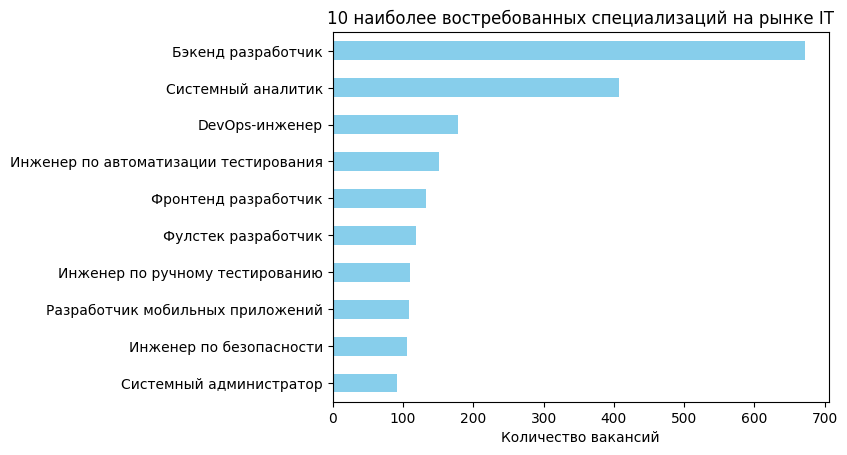

In [4]:
specs_top_df = vacs_df.sort_values(['Количество вакансий']).tail(10)
specs_top_df.plot(kind='barh', title = '10 наиболее востребованных специализаций на рынке IT', 
                      xlabel='Количество вакансий', ylabel='', legend=False, color='skyblue')

<h3>2. Show the 15 Most Required Skills for IT Specialist</h3>

<Axes: title={'center': '15 наиболее востребованных навыков на рынке IT'}, xlabel='Количество вакансий'>

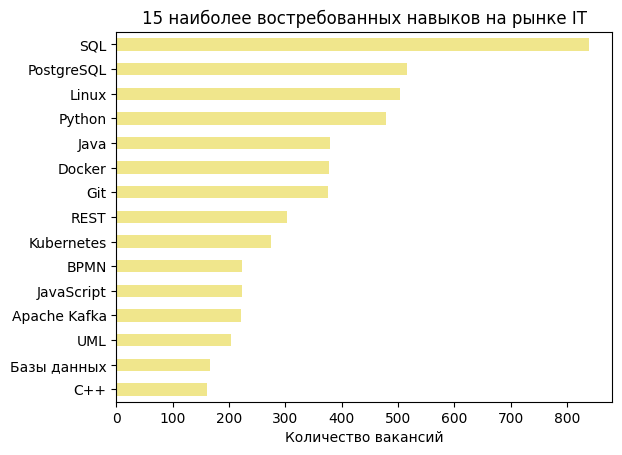

In [5]:
skills_top_df = skills_df.T.sum().sort_values().tail(15)
skills_top_df.plot(kind='barh', title = '15 наиболее востребованных навыков на рынке IT', 
                      xlabel='Количество вакансий', ylabel='', color='khaki')

<h3>3. Show the Distribution of IT Qualifications</h3>

<Axes: title={'center': 'IT Qualifications Distribution'}>

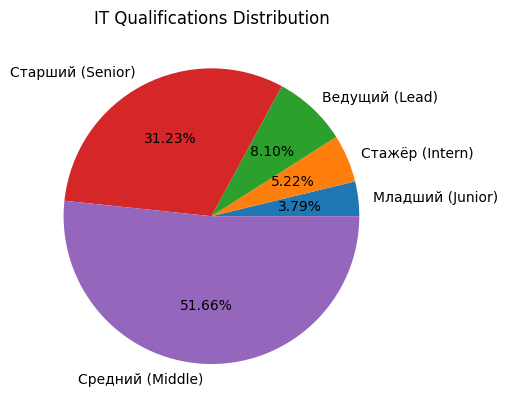

In [6]:
quals_sum_df = quals_df.T.sum().sort_values()
quals_sum_df.plot(kind='pie', title='Распространение IT квалификаций', autopct='%.2f%%')

<h3>4. Show the Most Entry-friendly IT Specializations</h3>

The plot is based on the percentage between Intern vacancies relative to the total number of vacancies of a given specialization. Only those specialties that have 20 or more vacancies were taken into account.

<Axes: title={'center': 'Наиболее входные специализации в IT'}, xlabel='Процент стажерских вакансий'>

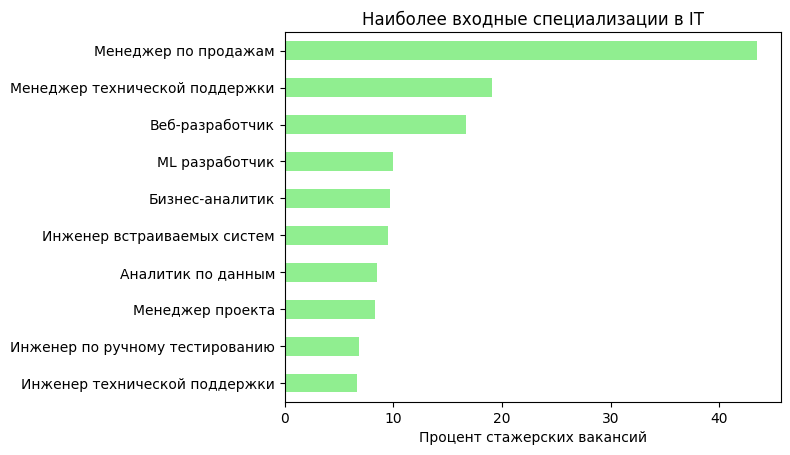

In [7]:
nf_df = quals_df.loc[:, quals_df.sum() >= 20]
nf_df = (nf_df / nf_df.sum() * 100).round(2).loc['Стажёр (Intern)'].sort_values().dropna().tail(10)
nf_df.plot(kind='barh', title='Наиболее входные специализации в IT', 
         xlabel='Процент стажерских вакансий', color='lightgreen')

<h3>5. Show Skill Comparison Between Data Analyst and Data Scientist specializations</h3>

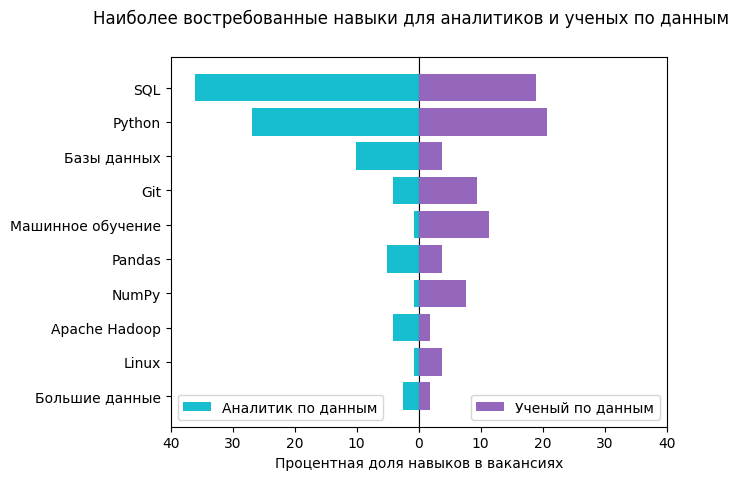

In [8]:
dads_df = skills_df.loc[(skills_df['Аналитик по данным'] > 0) & (skills_df['Ученый по данным'] > 0)][['Аналитик по данным', 'Ученый по данным']]
dads_df = (dads_df / dads_df.sum() * 100).round(2)
dads_sum = dads_df.T.sum().sort_values()
dads_df = dads_df.T[dads_sum.index[:]].T.tail(10)

fig, axes = plt.subplots(ncols=2, sharey=True)
xticks = [0, 10, 20, 30, 40]

axes[0].barh(dads_df.index, dads_df['Аналитик по данным'], align='center', color='C9', zorder=10)
axes[0].legend(['Аналитик по данным'])
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks)

axes[1].barh(dads_df.index, dads_df['Ученый по данным'], align='center', color='C4', zorder=10)
axes[1].legend(['Ученый по данным'])
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks)

axes[0].invert_xaxis() 
axes[1].tick_params(left = False)
plt.setp(axes[1].get_xticklabels()[0], visible=False)

fig.suptitle('Наиболее востребованные навыки для аналитиков и ученых по данным')
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Процентная доля навыков в вакансиях')

plt.show()